В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

Загрузка библиотек

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка базы

In [3]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)

'16_17.csv'

In [4]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')

In [5]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


In [6]:
# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [7]:
# Просмотр размерностей получившихся таблицы

print(data16_17.shape)

(263925, 5)


In [8]:
# Пример данных одного датасета
d = data16_17

print(d.shape[0])  # Всего записей (строк)
print(d.shape[1])  # Количество столбцов
print(d.iloc[0])   # Пример нулевой строки данных

263925
5
OPEN      2351.0
MAX       2355.8
MIN       2350.0
CLOSE     2350.0
VOLUME    2547.0
Name: 0, dtype: float64


In [9]:
# Создание общего набора данных из двух датасетов, 1 убрал, не хватает озу

data = pd.concat([data16_17]).to_numpy()

In [10]:
# Просмотр размерности новой таблицы

print(data16_17.shape)
print(data.shape)

(263925, 5)
(263925, 5)


In [11]:
# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

Иллюстрация данных в графическом виде

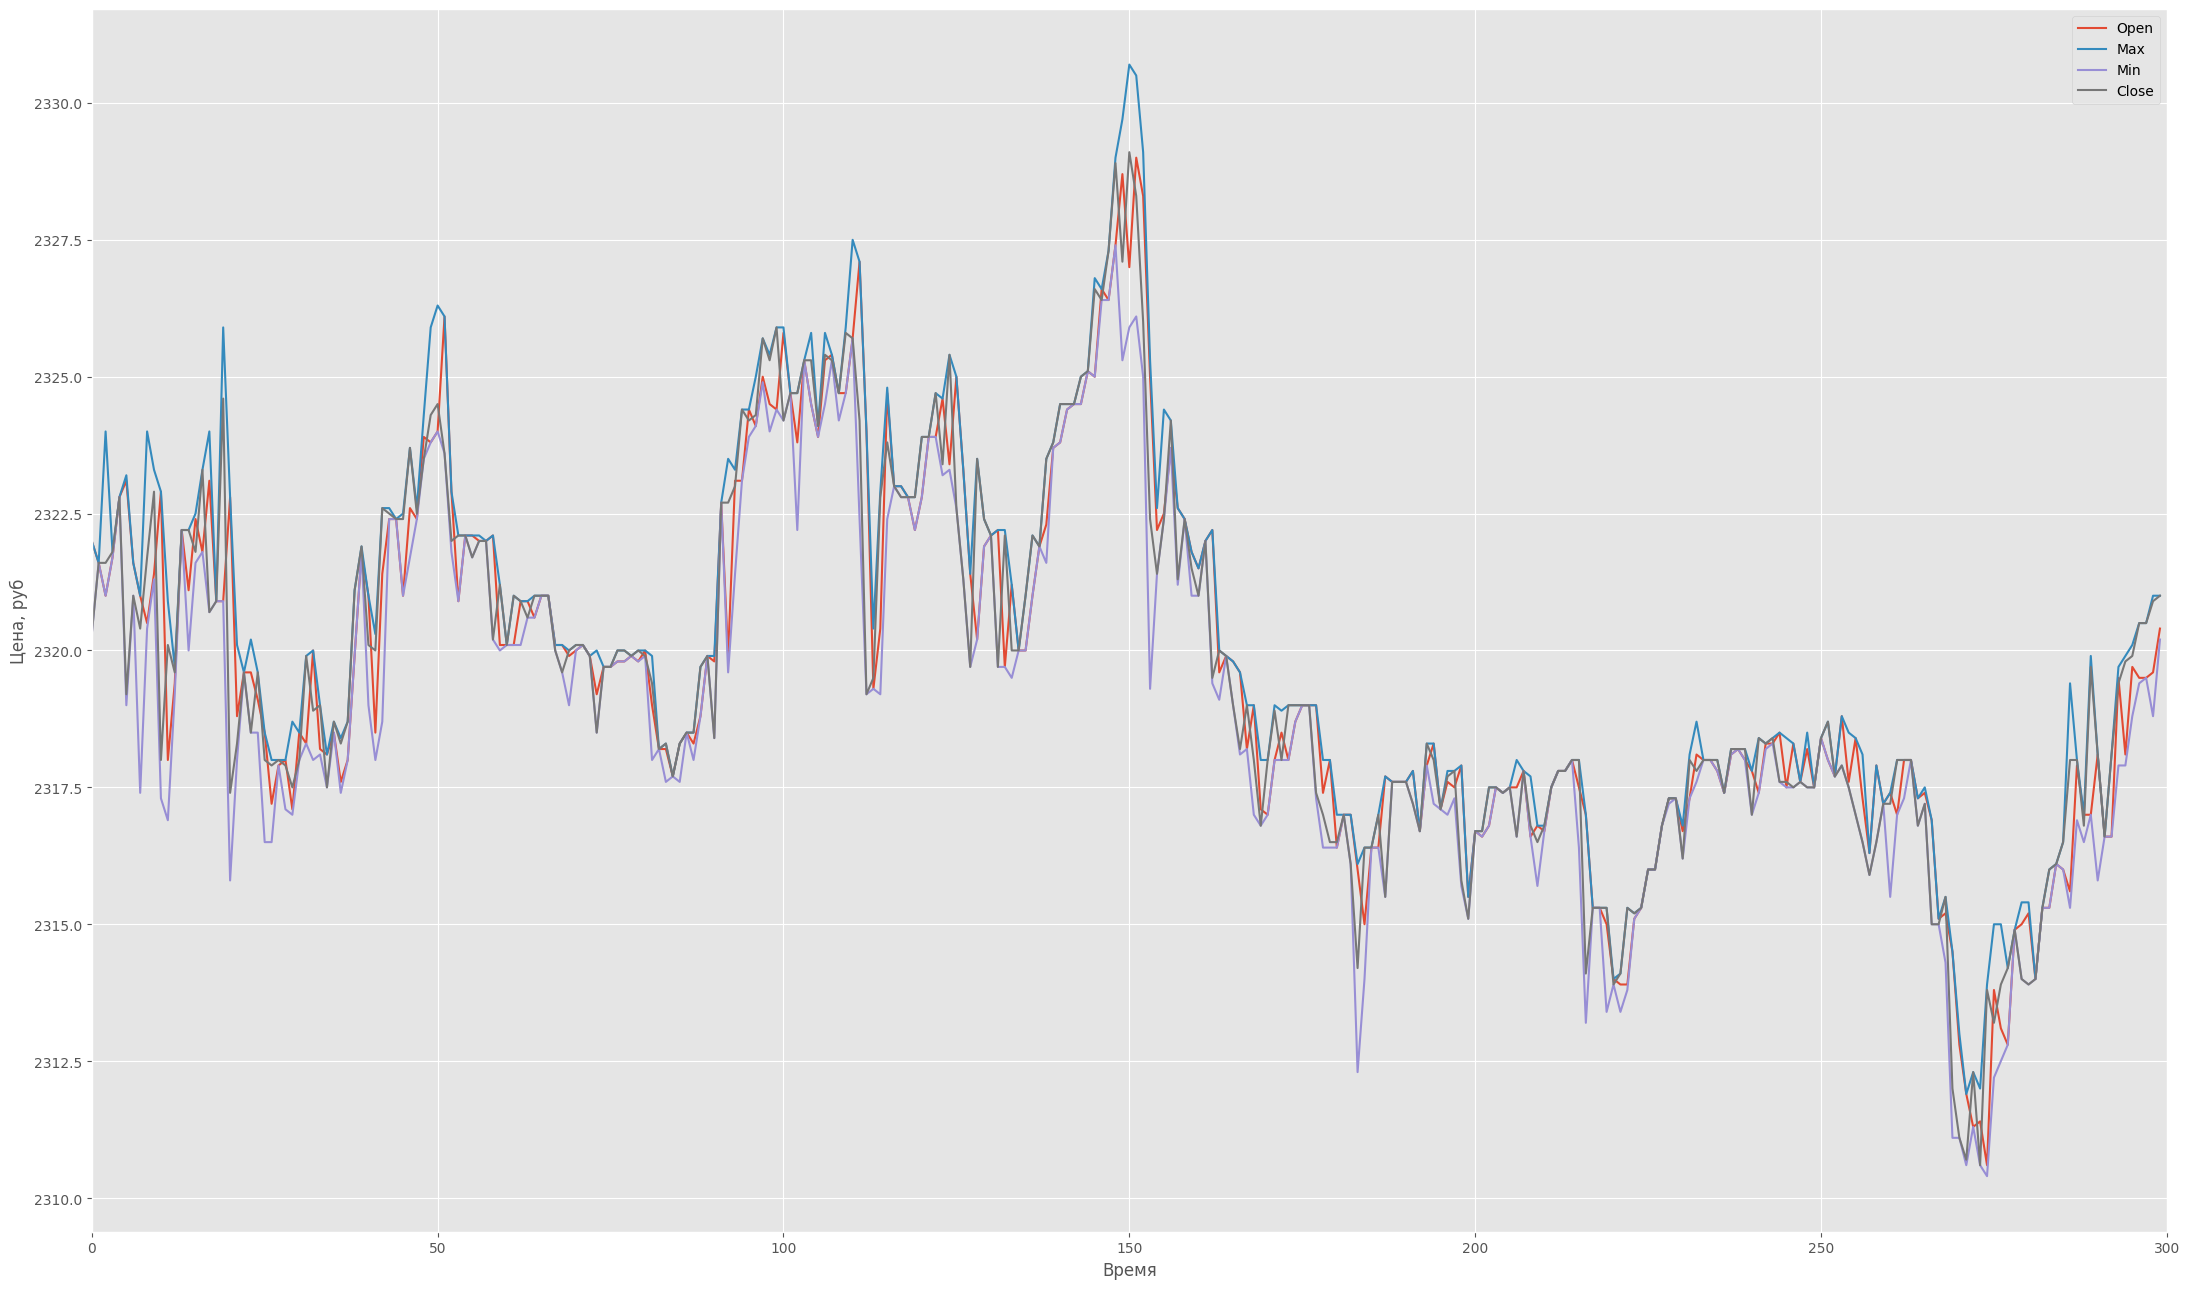

In [12]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()

In [13]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [14]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [15]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (233925, 5), (233925, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (20, 300, 5), y: (20, 1)


In [16]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (29100, 300, 5), y: (29100, 1)


Далее идут сервисные функции для обучения и вывода графиков как по примеру из практического файла 1.

In [17]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [18]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [19]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [20]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


In [21]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [22]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

Построим и обучим простую полносвязную сеть.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         9,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,793 (38.25 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - loss: 0.0302 - val_loss: 1.6105e-04
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - loss: 1.9659e-04 - val_loss: 1.7604e-04
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 1.6967e-04 - val_loss: 1.4871e-04
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - loss: 1.4929e-04 - val_loss: 9.8174e-05
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - loss: 1.2146e-04 - val_loss: 9.2551e-05
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 1.0270e-04 - val_loss: 8.2525e-05
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 8.8070e-05 - val_loss: 6.3873e-05
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - loss: 7.6279e-05 - val_loss: 5.4291e-05
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - loss: 6.7499e-05 - val_loss: 4.9277e-05
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - loss: 6.1859e-05 - val_loss: 6.6556e

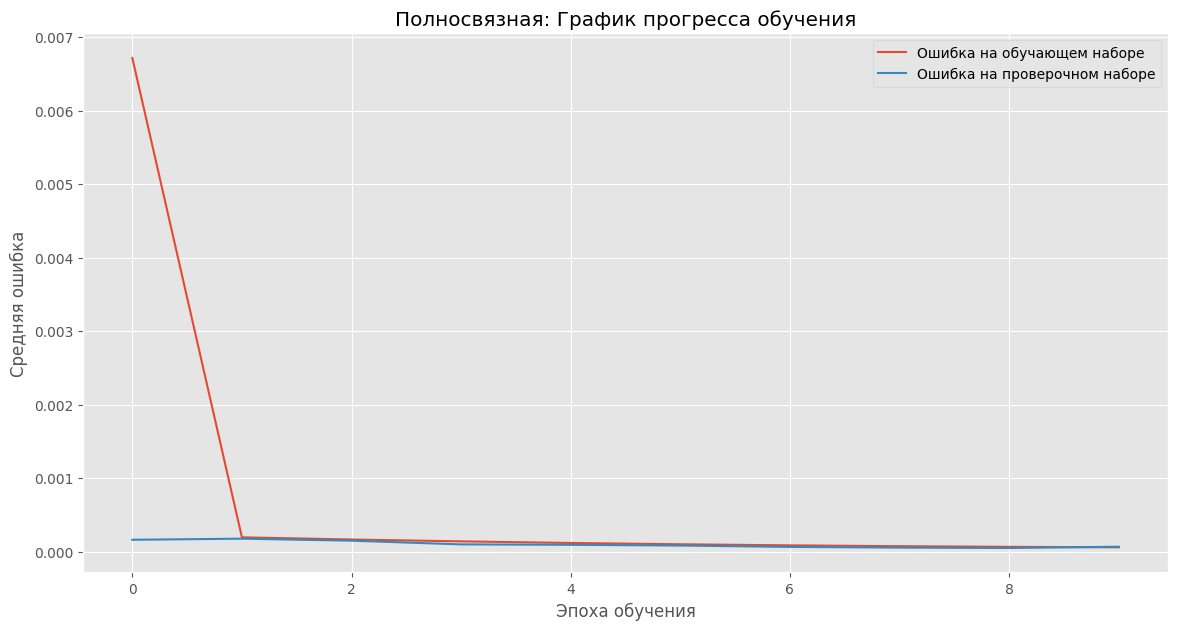

910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


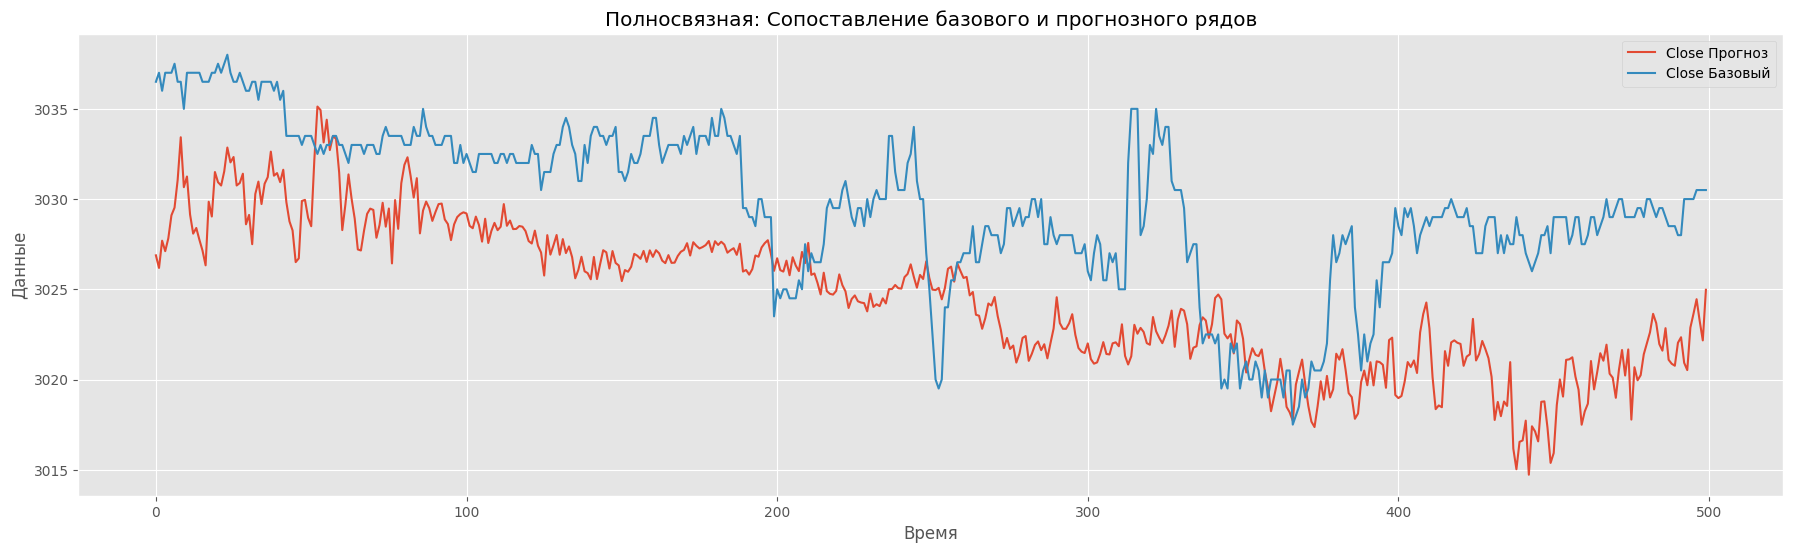

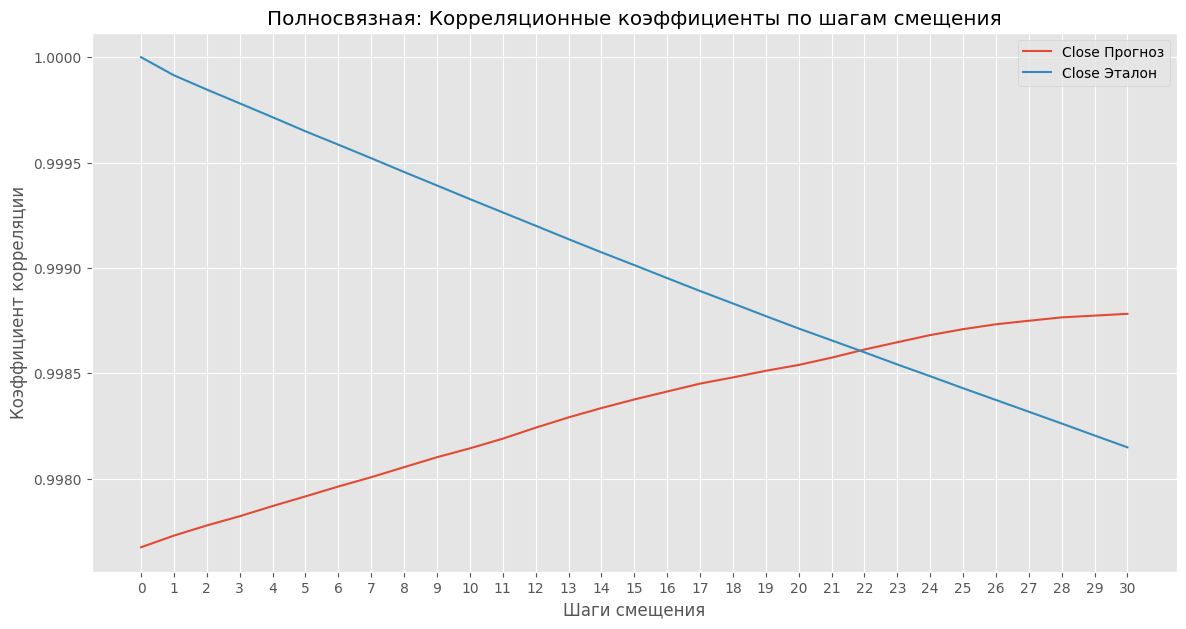

In [23]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(32, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 10 эпох для ускорения
train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

Подготовим данные и обучим ту же модель, но для 10 шагов вперед.

In [24]:
# Параметры
FORECAST_STEPS = 10  # Количество шагов предсказания вперед

# Подготовка y_data для многошагового предсказания
def prepare_multi_step_y(y_data, seq_len, forecast_steps):
    y_sequences = []
    for i in range(len(y_data) - seq_len - forecast_steps + 1):
        y_sequences.append(y_data[i+seq_len : i+seq_len+forecast_steps])
    return np.array(y_sequences)

In [25]:
# Параметры для многошагового прогноза
FORECAST_STEPS = 10  # горизонт прогноза (количество шагов вперед)

# Формирование выходных последовательностей из y (функция уже определена в ноутбуке)
y_train_multi = prepare_multi_step_y(y_data_train, SEQ_LEN, FORECAST_STEPS)
y_test_multi  = prepare_multi_step_y(y_data_test,  SEQ_LEN, FORECAST_STEPS)

# Обрезка x_data до длины, соответствующей новым y_multi
x_train_multi = x_data_train[:len(y_train_multi)]
x_test_multi  = x_data_test[:len(y_test_multi)]

# Создаем генераторы временных рядов для обучения и проверки (batch_size как в базовом примере)
train_datagen_multi = TimeseriesGenerator(x_train_multi, y_train_multi, length=SEQ_LEN, batch_size=BATCH_SIZE)
val_datagen_multi   = TimeseriesGenerator(x_test_multi,  y_test_multi,  length=SEQ_LEN, batch_size=BATCH_SIZE)

# Проверяем форму данных из генератора
x_batch, y_batch = train_datagen_multi[0]

print(f"Shape of batch X: {x_batch.shape}, Y: {y_batch.shape}")
# Ожидаемый вывод: X: (BATCH_SIZE, SEQ_LEN, num_features), Y: (BATCH_SIZE, FORECAST_STEPS, num_targets)

# Создаем генератор тестовых данных для многошагового прогноза
test_datagen_multi = TimeseriesGenerator(
    x_test_multi,
    y_test_multi,
    length=SEQ_LEN,        # длина последовательности (должна совпадать с SEQ_LEN)
    stride=1,
    sampling_rate=1,
    batch_size=BATCH_SIZE  # размер батча (должен совпадать с BATCH_SIZE)
)

# Формирование тестовой выборки из генератора
x_test_full, y_test_full = test_datagen_multi[0]

# Проверка формы тестовой выборки
print(f'Test x (multi-step): {x_test_multi.shape}, y (multi-step): {y_test_multi.shape}')

Shape of batch X: (20, 300, 5), Y: (20, 10, 1)
Test x (multi-step): (29091, 5), y (multi-step): (29091, 10, 1)


In [26]:
# Построение простой полносвязной модели для прогноза 10 шагов вперед
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(SEQ_LEN, x_train_multi.shape[1])))  # x_train_multi.shape[1] - число признаков на входе
model.add(Flatten())
model.add(Dense(FORECAST_STEPS, activation='linear'))  # выходной слой на 10 прогнозных значений

model.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        96,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,202 (375.79 KB)

 Trainable params: 96,202 (375.79 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Обучение модели в течение 10 эпох (как в исходном примере)
history = model.fit(
    train_datagen_multi,
    validation_data=val_datagen_multi,
    epochs=10,
    verbose=1
)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 87s 7ms/step - loss: 0.0670 - val_loss: 5.2634e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 5.7530e-04 - val_loss: 4.6656e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 5.8246e-04 - val_loss: 4.3954e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - loss: 5.5316e-04 - val_loss: 4.1937e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 5.5084e-04 - val_loss: 4.0581e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 5.5475e-04 - val_loss: 5.1238e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 5.2496e-04 - val_loss: 3.8466e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 5.0569e-04 - val_loss: 3.8411e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 151s 8ms/step - loss: 5.0827e-04 - val_loss: 3.7209e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - loss: 4.9686e-04 - val_loss: 3.7395e-04


910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


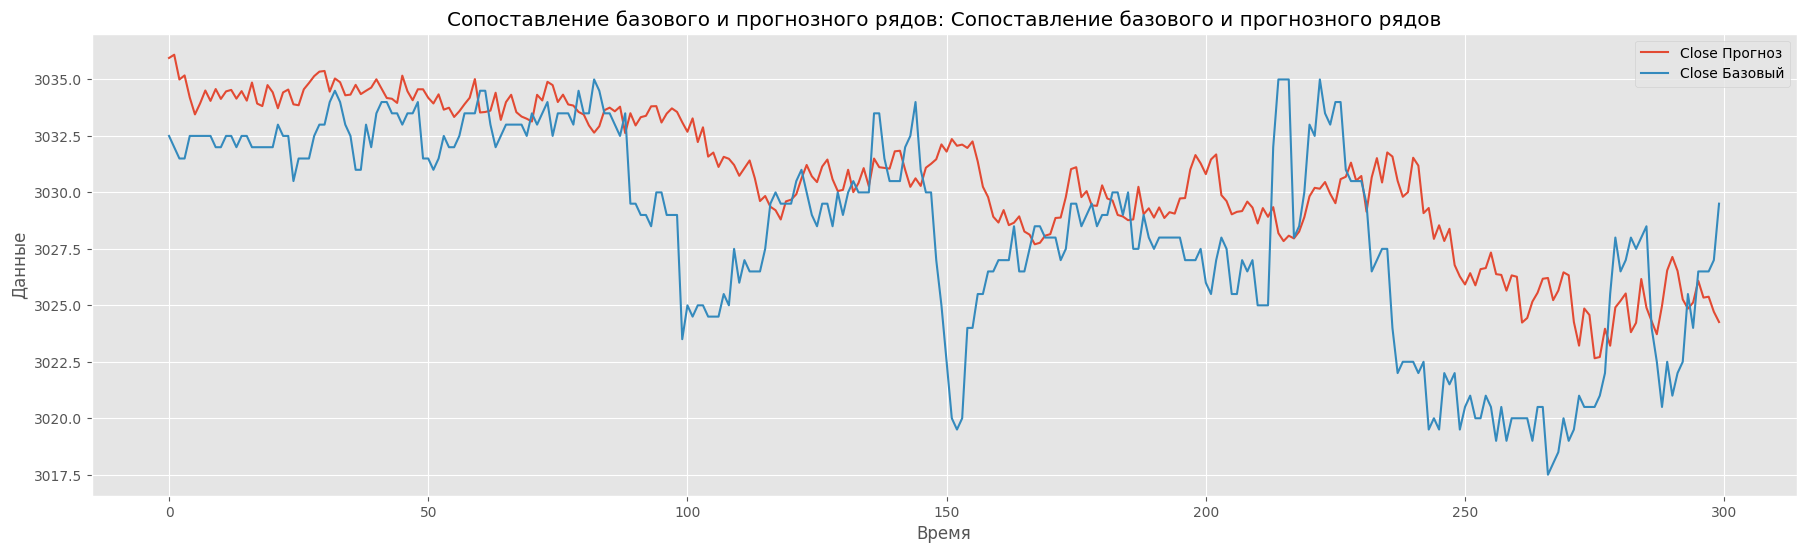

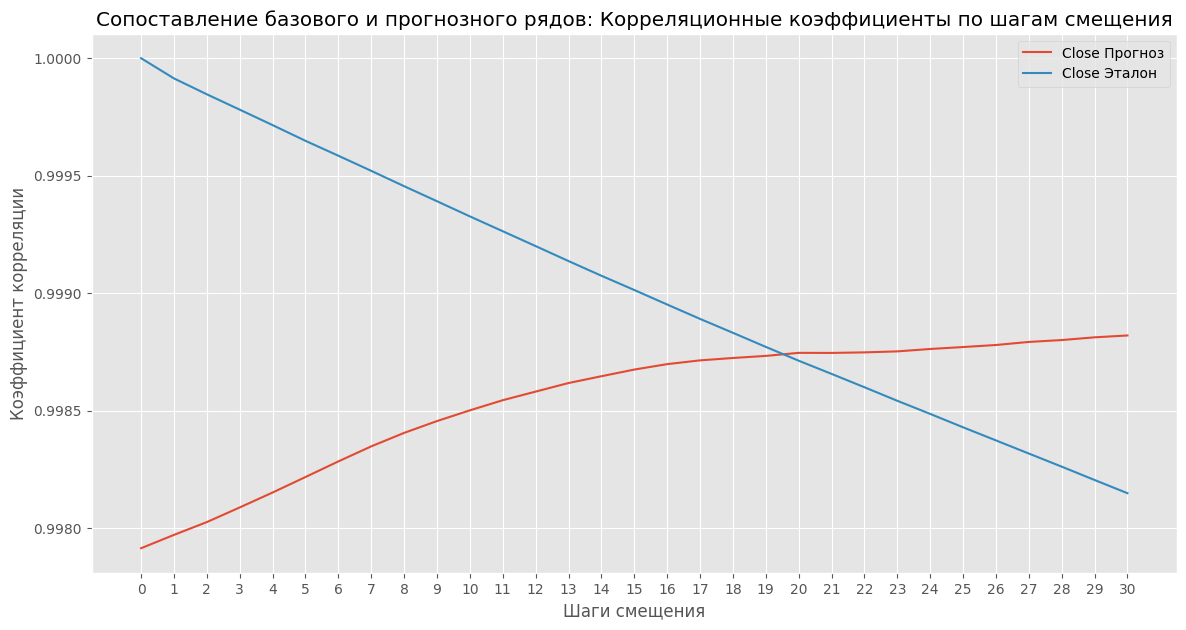

In [28]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [29]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


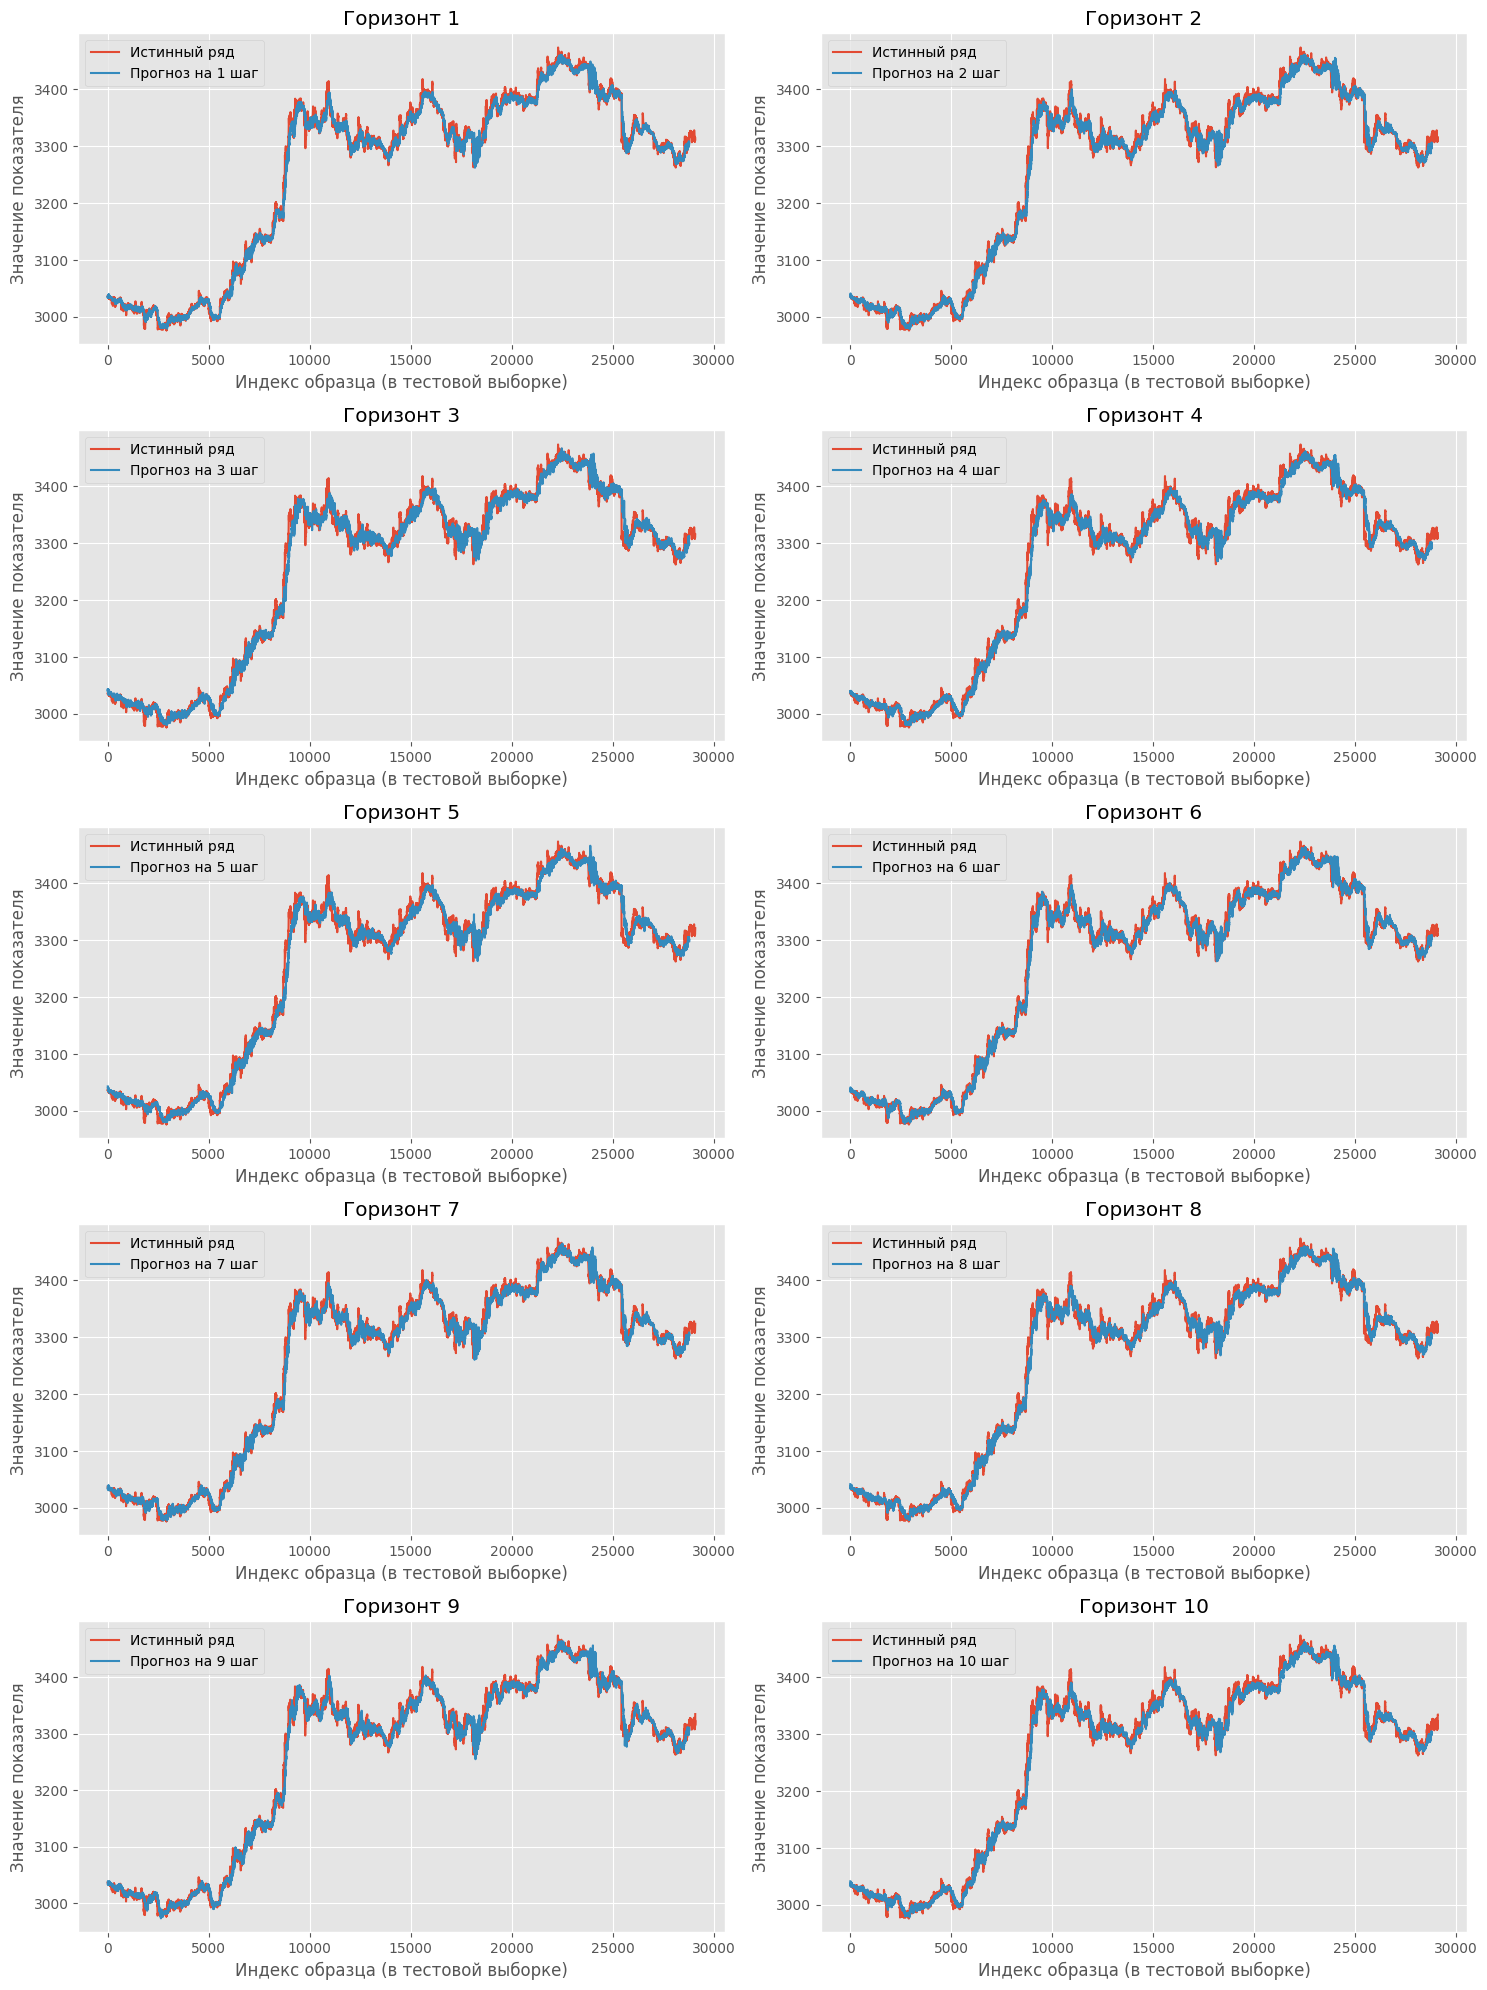

In [30]:
# Построение 10 графиков: истинные и предсказанные значения для каждого горизонта прогноза
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)  # размещаем графики в сетке 5x2
    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()

Теперь проделаем те же действия для сети с архитектурой

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 296, 50)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │       148,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,321 (583.29 KB)

 Trainable params: 149,321 (583.29 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 112s 9ms/step - loss: 0.0078 - val_loss: 7.4183e-05
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - loss: 1.2909e-04 - val_loss: 6.9512e-06
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 113s 10ms/step - loss: 3.9864e-05 - val_loss: 1.0829e-05
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - loss: 2.2919e-05 - val_loss: 4.2790e-06
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 114s 10ms/step - loss: 2.6079e-05 - val_loss: 5.0416e-06
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 109s 9ms/step - loss: 2.4134e-05 - val_loss: 2.6058e-06
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 115s 10ms/step - loss: 3.8907e-05 - val_loss: 2.4183e-06
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 115s 10ms/step - loss: 2.2542e-05 - val_loss: 6.0380e-06
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 119s 10ms/step - loss: 1.9013e-05 - val_loss: 1.4801e-04
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 141s 12ms/step - loss: 1.5976e-05 - 

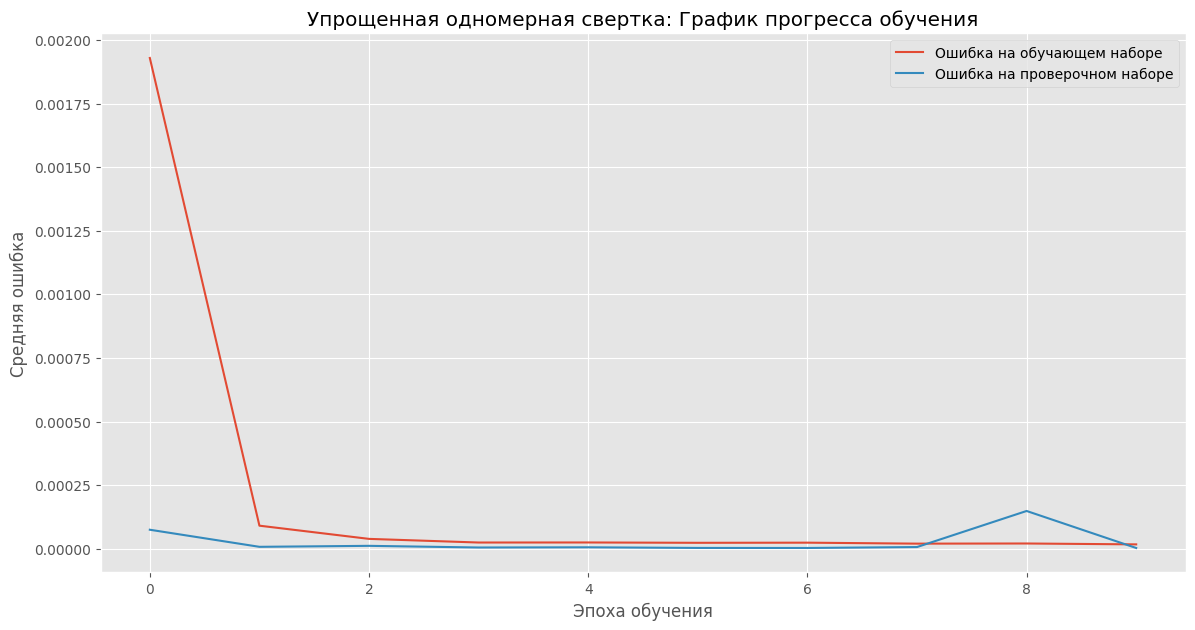

910/910 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


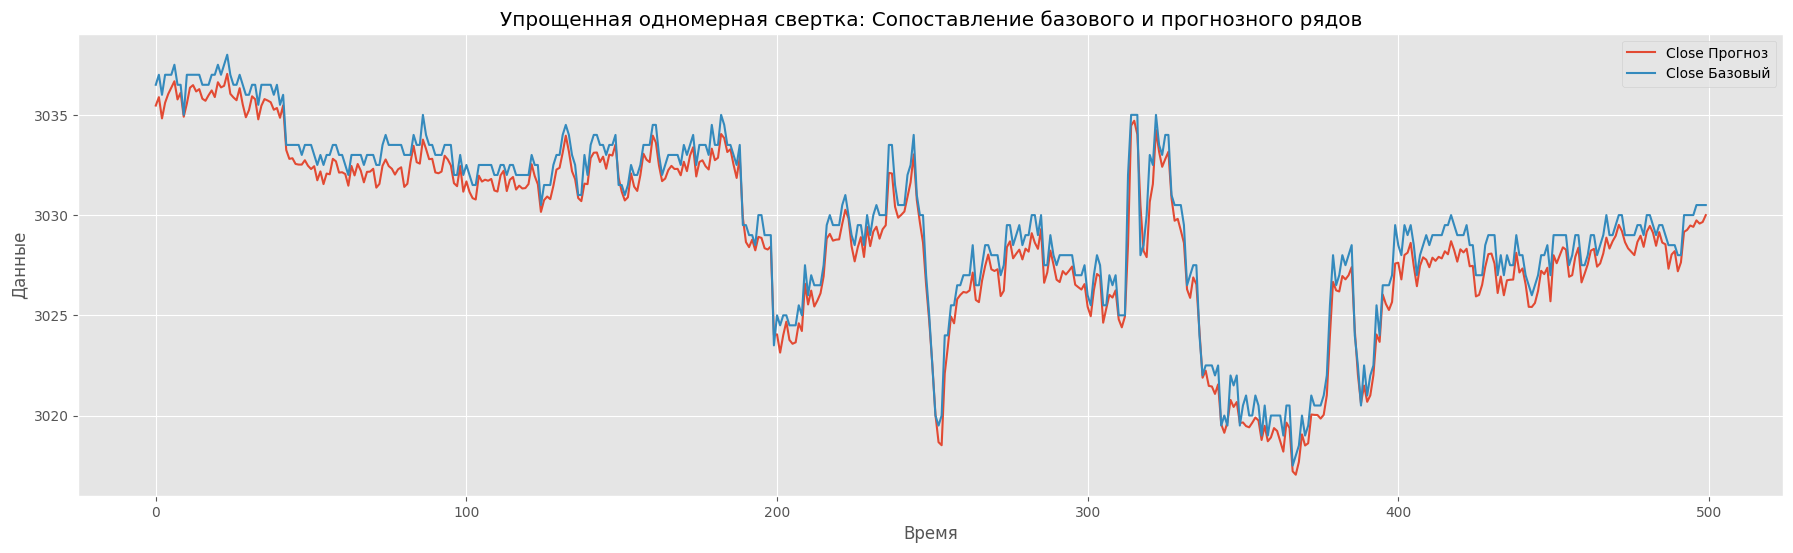

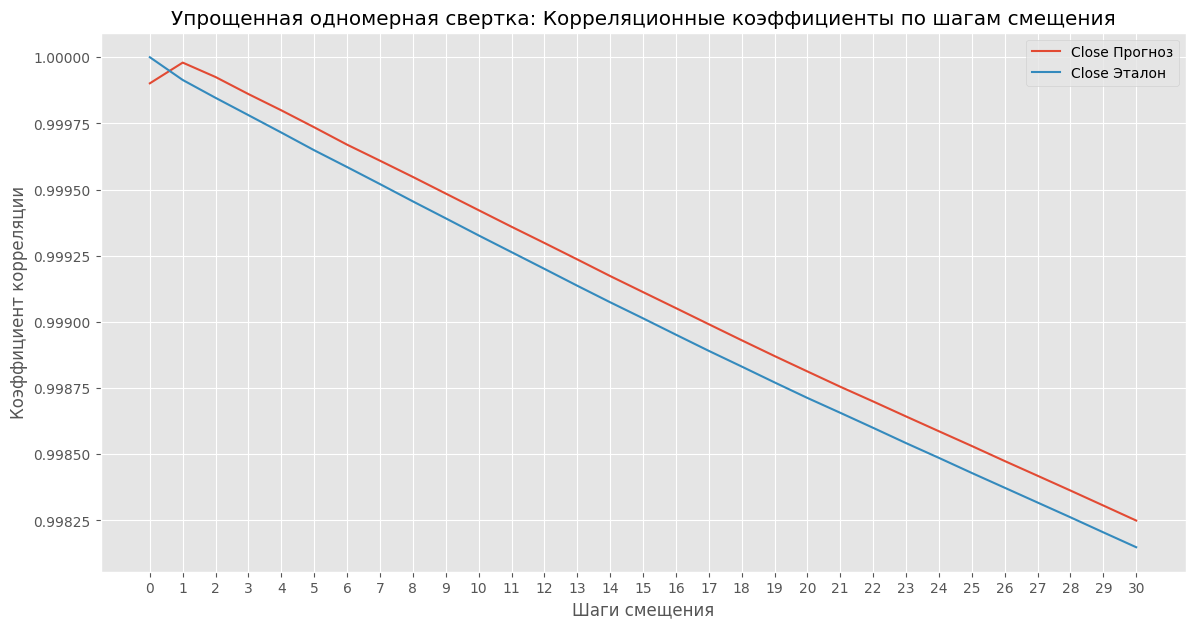

In [31]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 10 эпох
train_eval_net(model_conv_2, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4))],
               x_test, y_test, y_scaler, title='Упрощенная одномерная свертка')

In [34]:
# Напишем сеть той же архитектуры, но для предсказания 10 будущих значений
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(FORECAST_STEPS, activation='linear'))

model_conv_2.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model_conv_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 296, 50)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │       148,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,420 (583.67 KB)

 Trainable params: 149,420 (583.67 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Обучение модели в течение 10 эпох (как в исходном примере)
history = model_conv_2.fit(
    train_datagen_multi,
    validation_data=val_datagen_multi,
    epochs=10,
    verbose=1
)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 132s 11ms/step - loss: 0.0572 - val_loss: 4.5181e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 121s 10ms/step - loss: 5.9331e-04 - val_loss: 4.4439e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - loss: 5.8633e-04 - val_loss: 4.4067e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - loss: 5.6633e-04 - val_loss: 4.1907e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - loss: 5.5968e-04 - val_loss: 4.5369e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 117s 10ms/step - loss: 5.5209e-04 - val_loss: 4.0587e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 114s 10ms/step - loss: 5.4198e-04 - val_loss: 4.9434e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 114s 10ms/step - loss: 5.4478e-04 - val_loss: 4.0874e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 118s 10ms/step - loss: 5.3077e-04 - val_loss: 4.0203e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 107s 9ms/step - loss: 5.3632e-04 - val_loss: 4.210

910/910 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


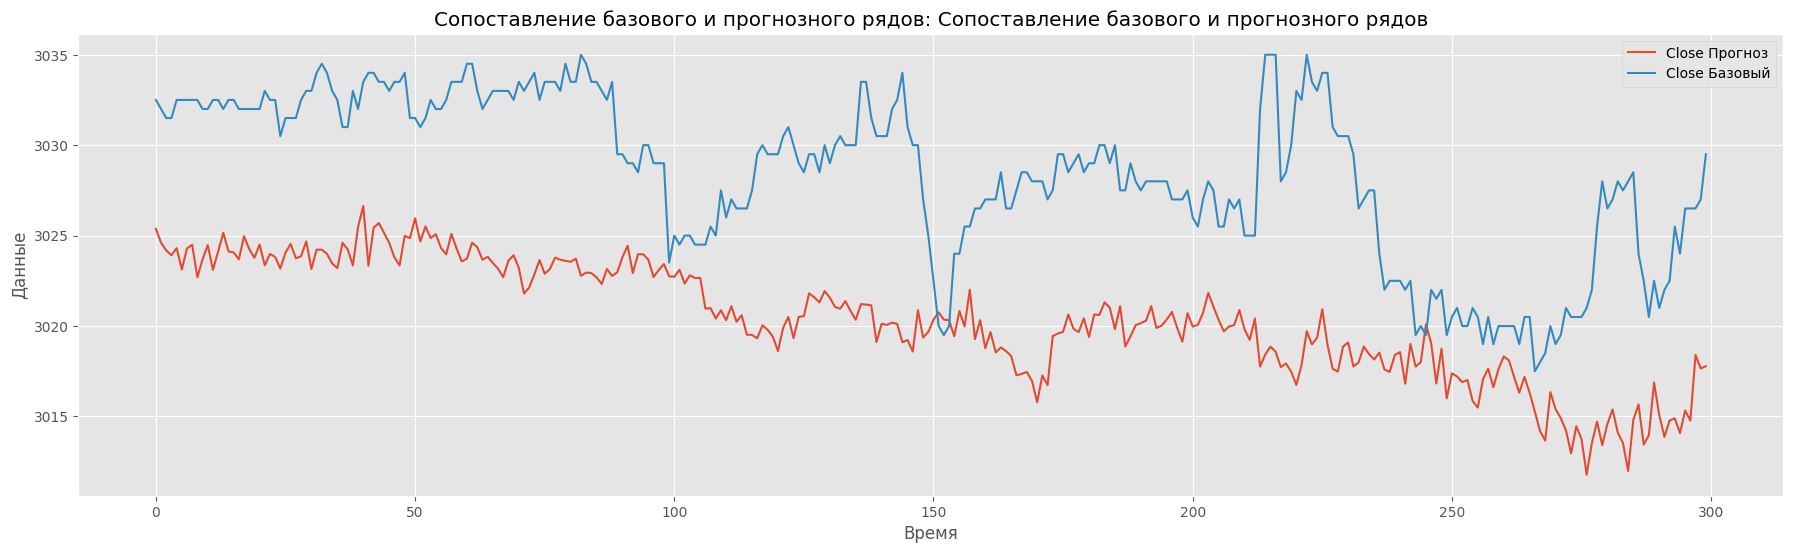

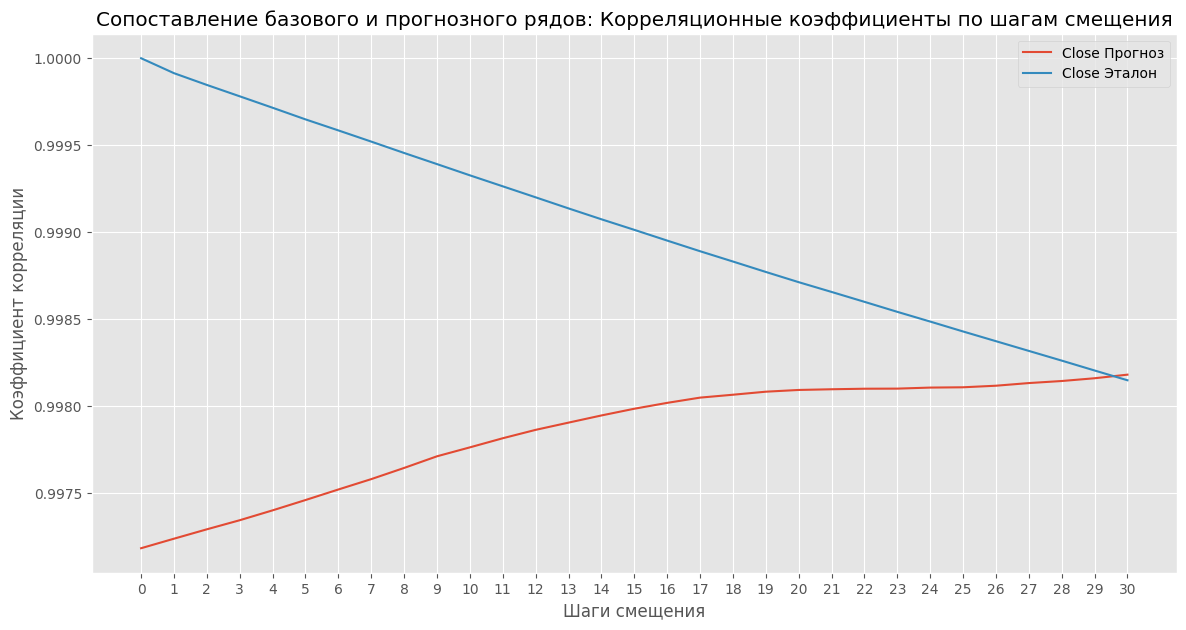

In [36]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv_2, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [37]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model_conv_2.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


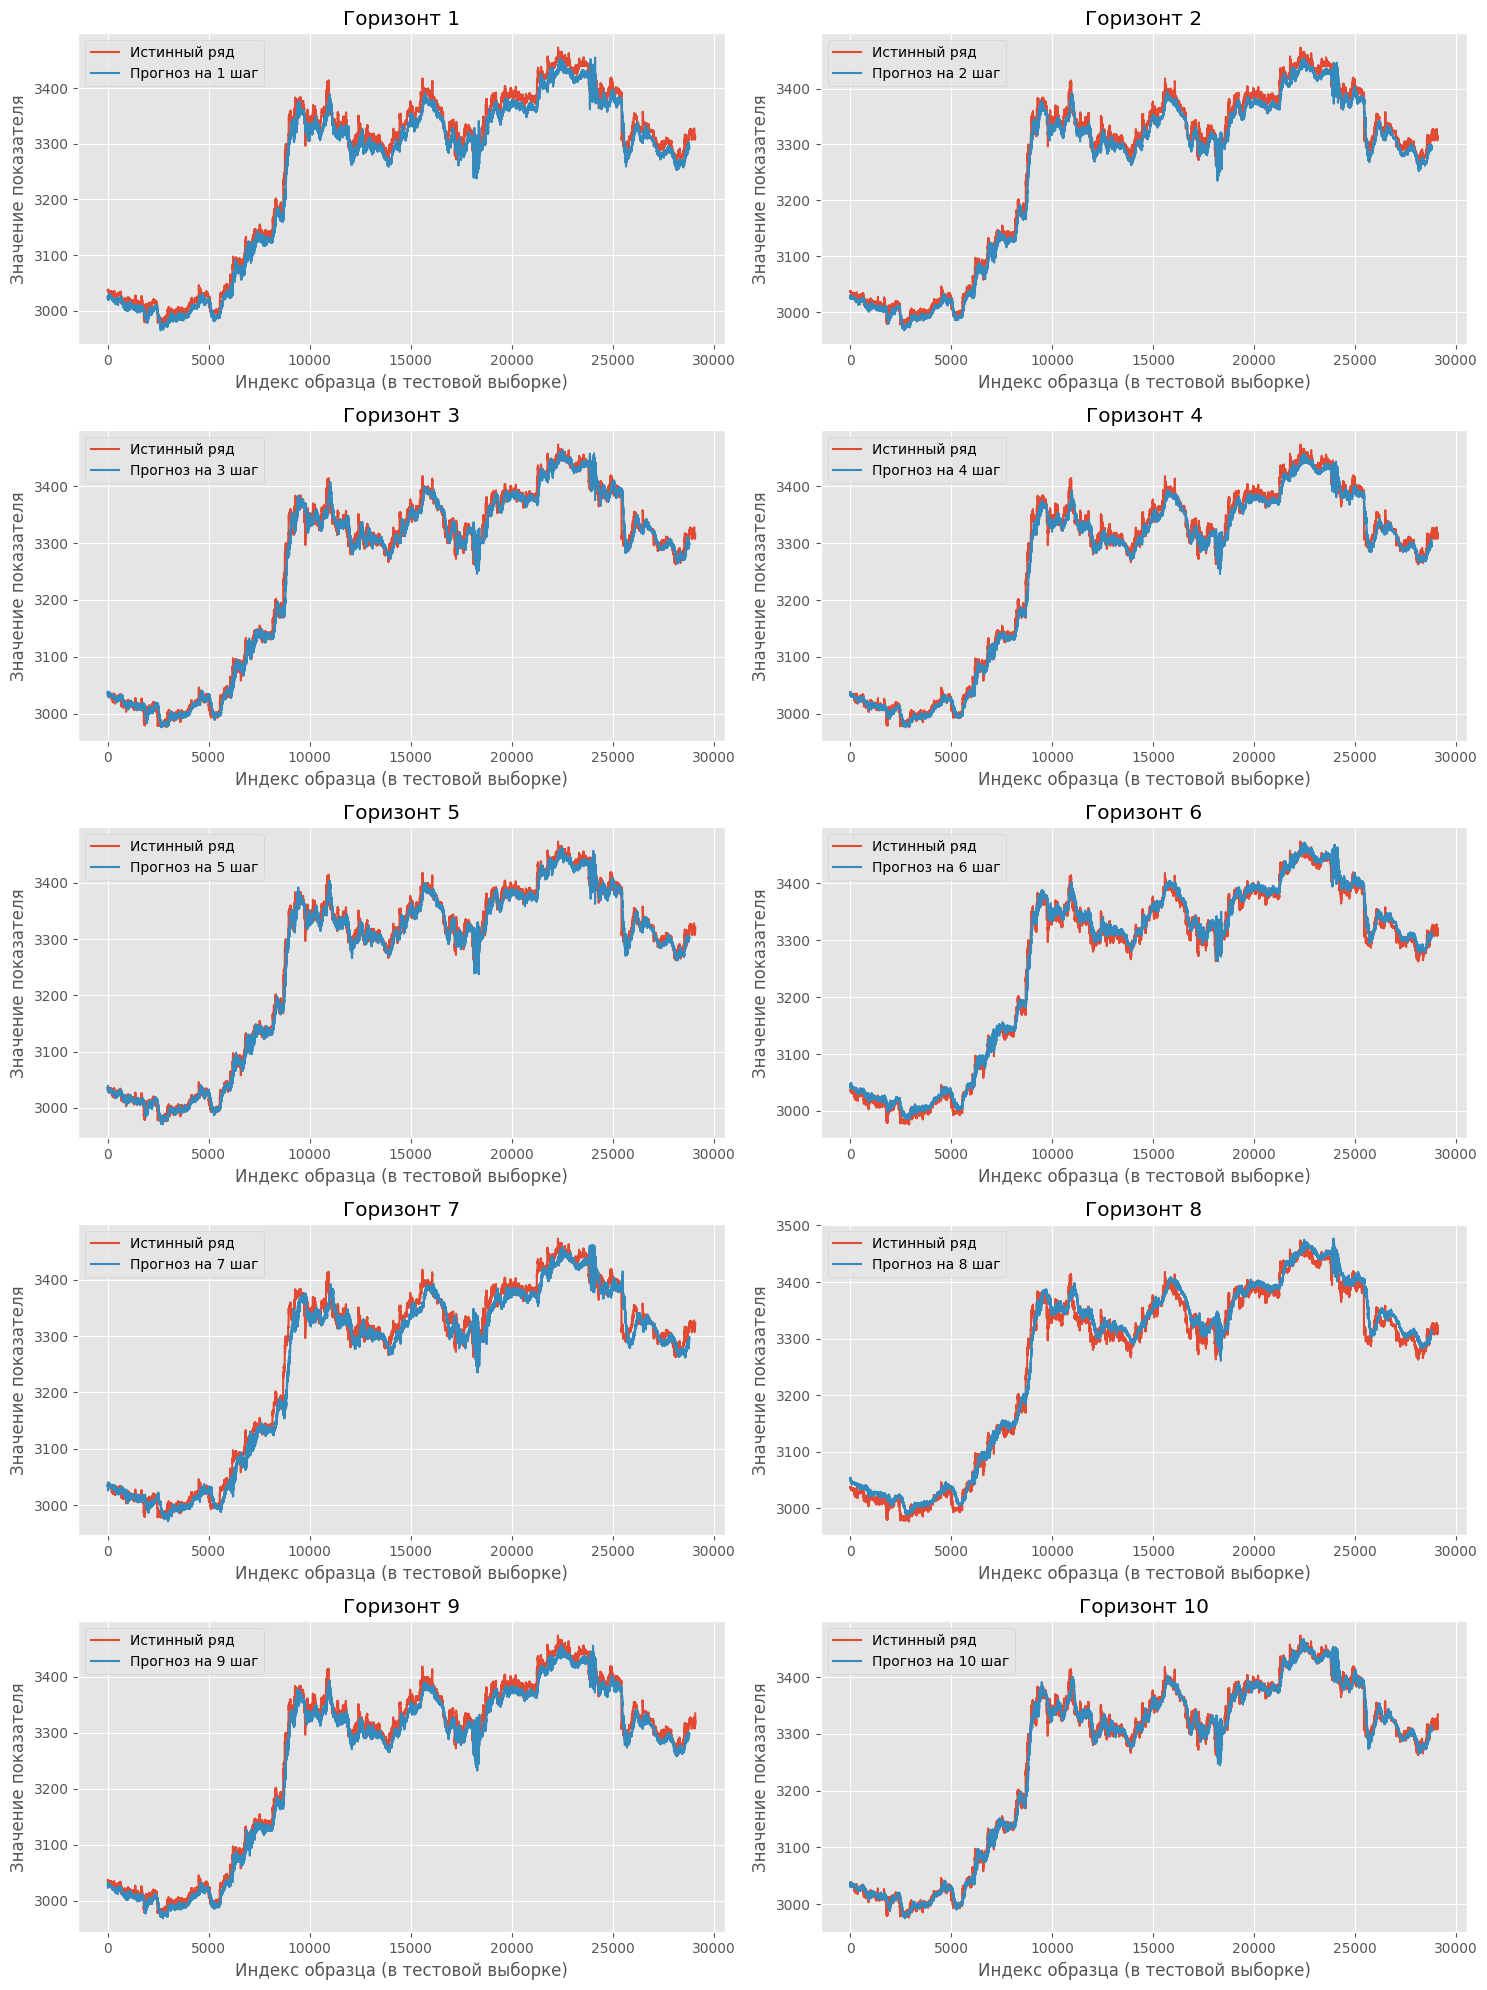

In [38]:
# Построение 10 графиков: истинные и предсказанные значения для каждого горизонта прогноза
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)  # размещаем графики в сетке 5x2
    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()